In [1]:
from MemSE import ROOT
from itertools import permutations, combinations
import matplotlib.pyplot as plt
import torch
import numpy as np

torch.backends.cudnn.benchmark = True
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

acc_convergence = np.load(ROOT / 'experiments/conference_2/results/acc_convergence.npy')
acc_convergence_cumavg = np.einsum('ij,j->ij', np.cumsum(acc_convergence, 1), 1/np.arange(1, acc_convergence.shape[1]+1))

/home/sebwood/projects/def-franlp/sebwood/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


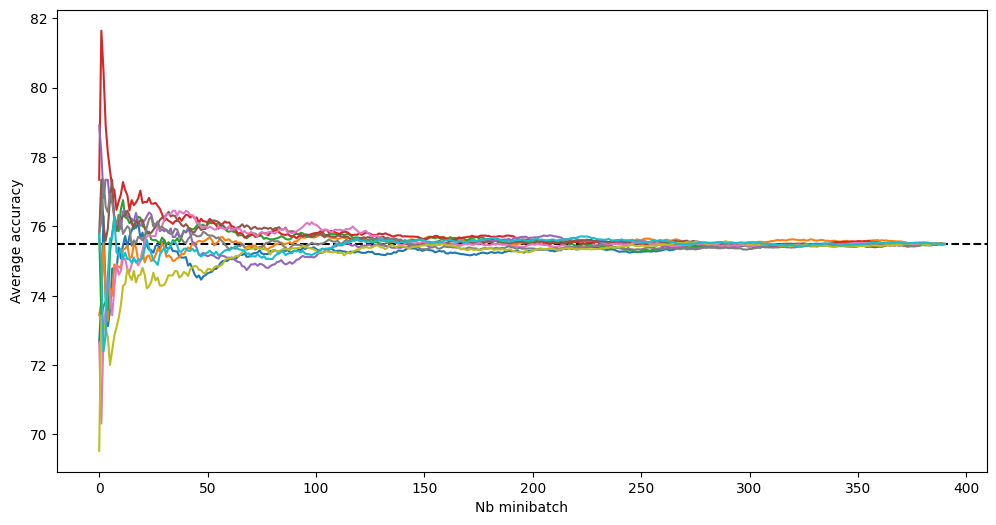

In [2]:
def get_cumavg(datapoints, random_perm:bool=False):
    if random_perm:
        datapoints = np.random.permutation(datapoints)
    return np.cumsum(datapoints) / np.arange(1, len(datapoints)+1)

def plot_one_permutation(datapoints, max_perm=10):
    fig, ax = plt.subplots(figsize=(12,6))
    avg = np.average(datapoints)
    ax.axhline(y=avg, color='black', linestyle='--')
    for _ in range(max_perm):
        ax.plot(get_cumavg(datapoints, True))
    ax.set_ylabel('Average accuracy')
    ax.set_xlabel('Nb minibatch')
    plt.show()
    plt.close()
    
plot_one_permutation(acc_convergence[0])

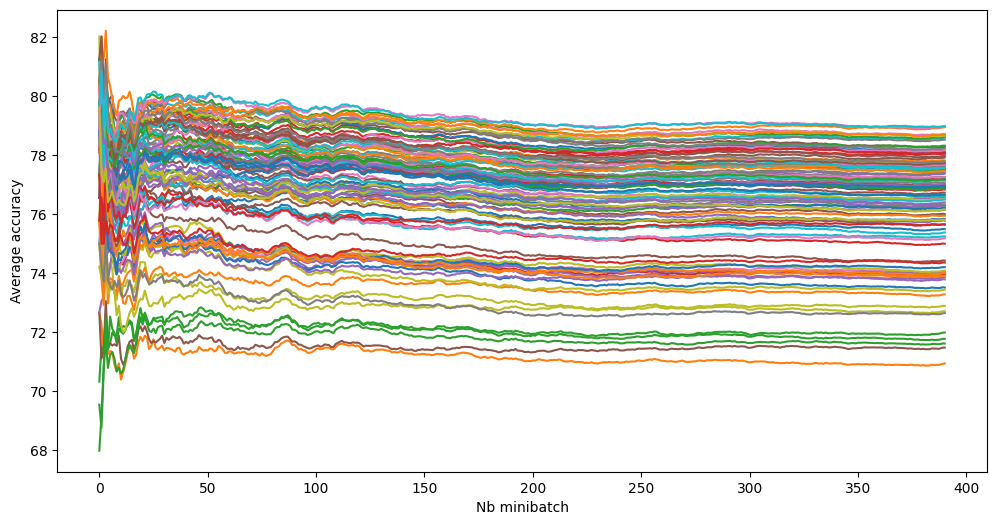

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
for idx in range(acc_convergence.shape[0]):
    ax.plot(get_cumavg(acc_convergence[idx]))

ax.set_ylabel('Average accuracy')
ax.set_xlabel('Nb minibatch')
plt.show()
plt.close()

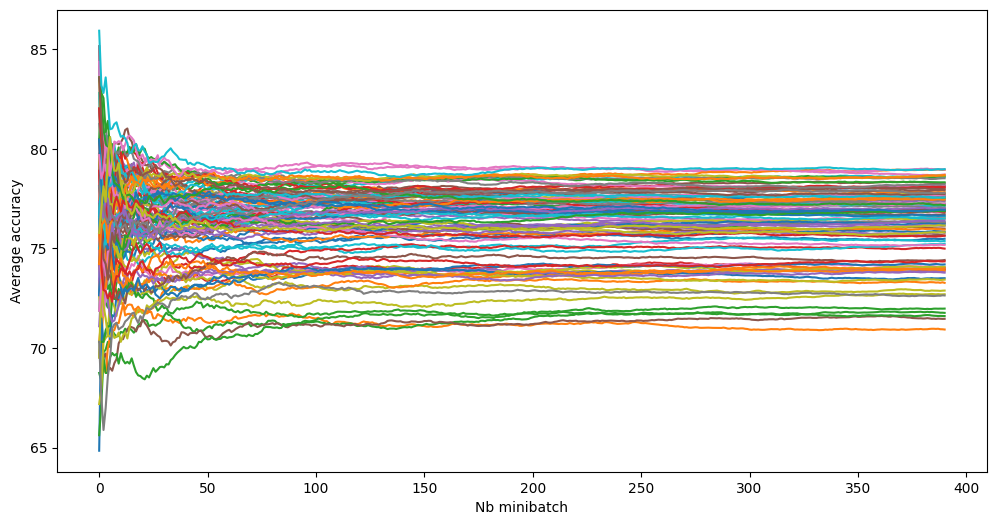

In [ ]:
fig, ax = plt.subplots(figsize=(12,6))
for idx in range(acc_convergence.shape[0]):
    ax.plot(get_cumavg(acc_convergence[idx], True))

ax.set_ylabel('Average accuracy')
ax.set_xlabel('Nb minibatch')
plt.show()
plt.close()

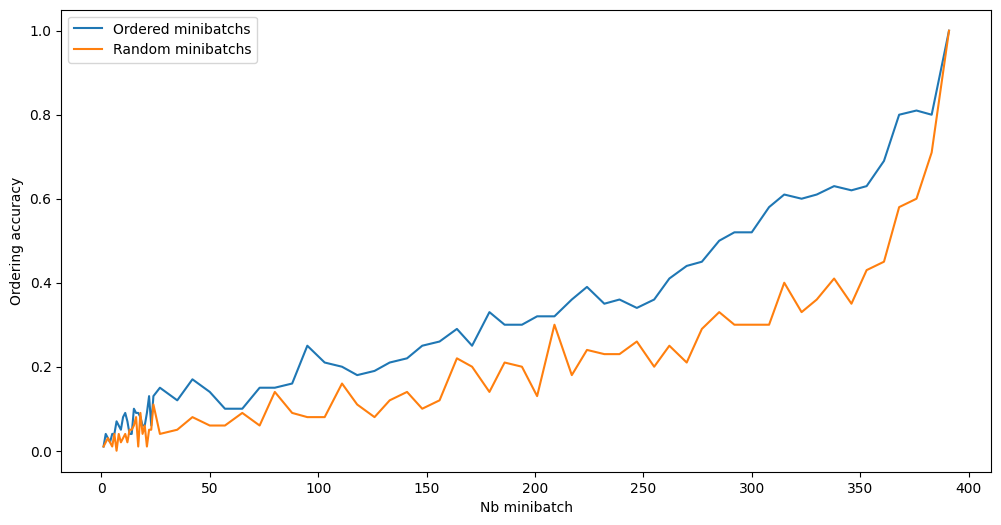

In [ ]:
ref_ordering = [[idx, np.average(acc_convergence[idx])] for idx in range(acc_convergence.shape[0])]
ref_ordering = sorted(ref_ordering, key=lambda x: x[1])

def get_order(random_perm:bool=False, minibatch=None):
    assert 0 < minibatch <= acc_convergence.shape[1]
    ref_ordering = []
    for idx in range(acc_convergence.shape[0]):
        if random_perm:
            points = np.random.permutation(acc_convergence[idx])[:minibatch]
        else:
            points = acc_convergence[idx,:minibatch]
        ref_ordering.append([idx, np.average(points)])
    ref_ordering = sorted(ref_ordering, key=lambda x: x[1])
    return ref_ordering

def get_accuracy_ordering(order_ref, order_other):
    ord_ref = [x[0] for x in order_ref]
    ord_oth = [x[0] for x in order_other]
    return sum([r == o for r, o in zip(ord_ref, ord_oth)])/len(order_ref)


def sweep_minibatch_ordering(random_perm:bool=False):
    order_accuracies = {}
    for nb_mb in range(1, 25):
        order = get_order(random_perm=random_perm, minibatch=nb_mb)
        res = get_accuracy_ordering(ref_ordering, order)
        order_accuracies[nb_mb] = res

    for percent in np.linspace(0.05, 1):
        minibatch = round(percent * acc_convergence.shape[1])
        order = get_order(random_perm=random_perm, minibatch=minibatch)
        res = get_accuracy_ordering(ref_ordering, order)
        order_accuracies[minibatch] = res
    return order_accuracies


fig, ax = plt.subplots(figsize=(12,6))

order_accuracies = sweep_minibatch_ordering()
sorted_oa = sorted(order_accuracies.items())
plt.plot(*zip(*sorted_oa), label='Ordered minibatchs')

order_accuracies = sweep_minibatch_ordering(random_perm=True)
sorted_oa = sorted(order_accuracies.items())
plt.plot(*zip(*sorted_oa), label='Random minibatchs')

ax.set_xlabel('Nb minibatch')
ax.set_ylabel('Ordering accuracy')
ax.legend()
plt.show()
plt.close()

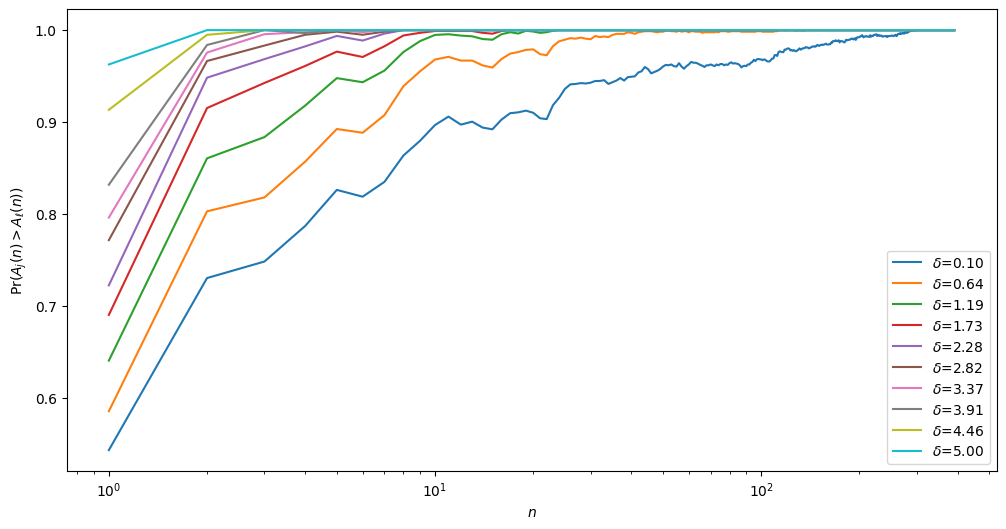

In [2]:
class AverageMeter:
    def __init__(self):
        self.hit, self.total = 0, 0
        
    def __repr__(self):
        return str(self.average())
        
    def average(self):
        return self.hit / self.total

def compute_pr(delta:float=1., N: int = None):
    if N is None:
        N = range(acc_convergence.shape[1])
    else:
        assert isinstance(N, int)
        N = [N]
    average = {}
    for (k1, k2) in combinations(range(acc_convergence.shape[0]), 2):
        k1_acc, k2_acc = acc_convergence_cumavg[k1], acc_convergence_cumavg[k2]
        if k1_acc[-1] > k2_acc[-1] + max(0, delta):
            for n in N: # for each minibatch pick
                if not n in average:
                    average[n] = AverageMeter()
                
                if k1_acc[n] > k2_acc[n]:
                    average[n].hit += 1
                average[n].total += 1
    return average
            
fig, ax = plt.subplots(figsize=(12,6))
for delta in np.linspace(0.1, 5, 10):
    ax.plot(*zip(*[(idx + 1, meter.average()) for idx, meter in compute_pr(delta).items()]), label=fr'$\delta$={delta:.2f}')
ax.set_ylabel('$\Pr(A_j(n) > A_\ell(n))$')
ax.set_xlabel('$n$')
ax.set_xscale('log')
ax.legend()
plt.show()
plt.close()

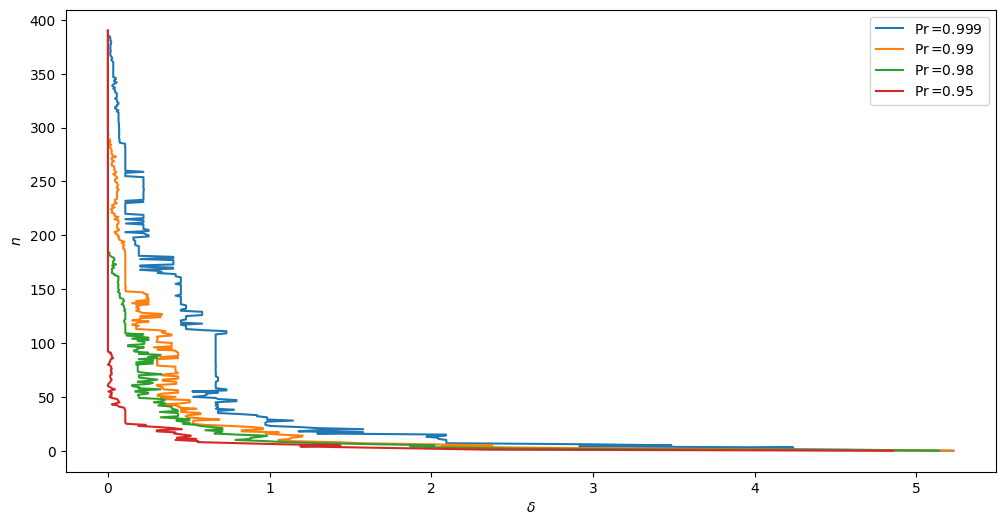

In [3]:
def compute_delta(prob:float=0.99):
    N = acc_convergence.shape[1]
    delta = []
    for n in range(N):
        delta_i = 5.
        cp_delta = delta_i
        for i in range(100):
            avg = compute_pr(delta_i, n)
            if n in avg and avg[n].average() < prob: # delta is a valid choice and avg is populated
                delta_i += cp_delta / (i + 1)
            elif n not in avg or avg[n].average() > prob: # delta is too high of a constraint
                delta_i -= cp_delta / (i + 1)
            elif n in avg and avg[n].average() == prob:
                break
        delta.append(max(0.,delta_i))
    return delta

delta_dict = {}
fig, ax = plt.subplots(figsize=(12,6))
for prob in [0.999, 0.99, 0.98, 0.95]:
    delta_dict[prob] = compute_delta(prob)
    ax.plot(delta_dict[prob], list(range(acc_convergence.shape[1])), label=f'$\Pr$={prob}')
ax.set_ylabel('$n$')
ax.set_xlabel('$\delta$')
ax.legend()
plt.show()
plt.close()

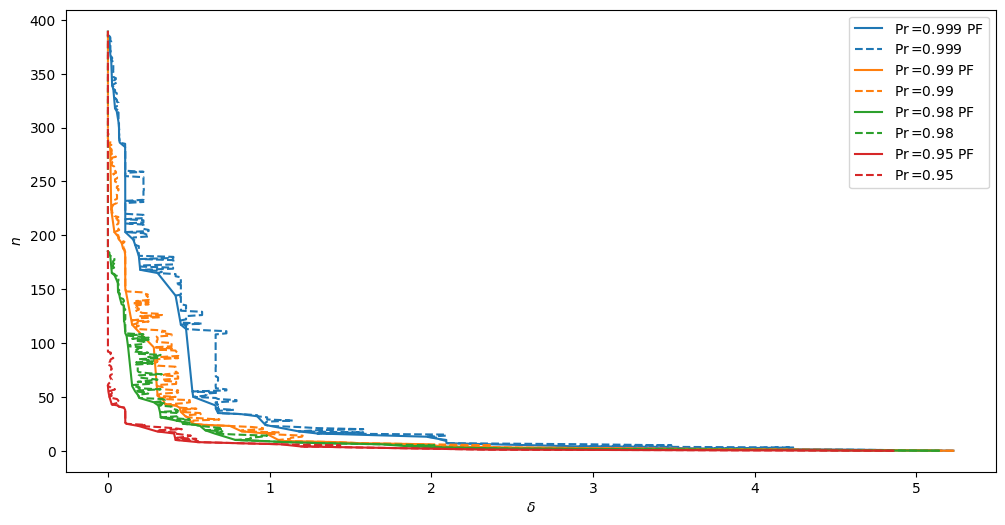

In [4]:
def plot_pareto_frontier(Xs, Ys, maxX=True, maxY=False):
    '''Pareto frontier selection process'''
    sorted_list = sorted([[Xs[i], Ys[i]] for i in range(len(Xs))], reverse=maxY)
    pareto_front = [sorted_list[0]]
    for pair in sorted_list[1:]:
        if maxY:
            if pair[1] >= pareto_front[-1][1]:
                pareto_front.append(pair)
        else:
            if pair[1] <= pareto_front[-1][1]:
                pareto_front.append(pair)
    pf_X = [pair[0] for pair in pareto_front]
    pf_Y = [pair[1] for pair in pareto_front]
    return pf_X, pf_Y

fig, ax = plt.subplots(figsize=(12,6))
N = list(range(acc_convergence.shape[1]))
for prob in [0.999, 0.99, 0.98, 0.95]:
    d = delta_dict[prob]
    pf_X, pf_Y = plot_pareto_frontier(d, N)
    p = ax.plot(pf_X, pf_Y, label=f'$\Pr$={prob} PF')
        
    # b, a = np.polyfit(d, np.log(np.array(N)+1e-6), 1)
    # ranging = np.linspace(min(d), max(d), 50)
    # p = ax.plot(ranging, np.exp(a + b * ranging), label=f'$\Pr$={prob} EF')
    ax.plot(d, list(range(acc_convergence.shape[1])), label=f'$\Pr$={prob}', color=p[0].get_color(), linestyle='--')
ax.set_ylabel('$n$')
ax.set_xlabel('$\delta$')
#ax.set_xscale('log')
ax.legend()
plt.show()
plt.close()